# Grid sampling

In [20]:
%cd "~/lab/stage"
from src.problems.two_dimensional import *
import pandas as pd
test_geometry = MissionGeometry()
test_design = NOmegaPointsScaleBasedPeriodic(int(test_geometry.P_s / 10), 3)
test_spacecraft = Spacecraft()
test_problem = AttitudeTrajectoryProblem2D(test_geometry, test_spacecraft, test_design)

/home/ggarrett/lab/stage


## Uninformed Domain Grid Sampling

In [12]:
def grid_sample_domain(bounds, n_sample_dim, flatten=True):
    assert len(bounds[0]) == len(bounds[1])
    if type(n_sample_dim) is int:
        linspace = [np.linspace(bounds[0][i], bounds[1][i], n_sample_dim) for i in range(len(bounds[0]))]
    elif hasattr(n_sample_dim, '__iter__'):
        try:
            assert len(n_sample_dim) == len(bounds[0])
        except AssertionError:
            raise AssertionError(f"Length of n_sample_dim not correct {len(n_sample_dim)}!={len(bounds[1])}")
        linspace = [np.linspace(bounds[0][i], bounds[1][i], n_sample_dim[i]) for i in range(len(bounds[0]))]
    _return = np.array(np.meshgrid(*linspace))
    _return = np.array([_return_i.flatten() for _return_i in _return.reshape(len(bounds[0]), -1)]).T if flatten else _return
    return _return

In [388]:
# %%timeit
res1 = grid_sample_domain([[0,0],[1,1]],[3,4])
np.round(res1, 2)

array([[0.  , 0.  ],
       [0.5 , 0.  ],
       [1.  , 0.  ],
       [0.  , 0.33],
       [0.5 , 0.33],
       [1.  , 0.33],
       [0.  , 0.67],
       [0.5 , 0.67],
       [1.  , 0.67],
       [0.  , 1.  ],
       [0.5 , 1.  ],
       [1.  , 1.  ]])

## Random Domain Sampling

In [6]:
def random_uniform_sample_domain(bounds, n_samples, seed=101):
    np.random.seed(seed)
    return np.random.uniform(bounds[0], bounds[1], (n_samples, len(bounds[0])))

In [7]:
%%timeit
res2 = random_uniform_sample_domain([[0,0],[1,1]], 3**2)
np.round(res2, 2)

13.8 µs ± 66.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Halton Domain Sampling

In [8]:
"""Halton low discrepancy sequence.
This snippet implements the Halton sequence following the generalization of
a sequence of *Van der Corput* in n-dimensions.
---------------------------
MIT License
Copyright (c) 2017 Pamphile Tupui ROY
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""
import numpy as np


def primes_from_2_to(n):
    """Prime number from 2 to n.
    From `StackOverflow <https://stackoverflow.com/questions/2068372>`_.
    :param int n: sup bound with ``n >= 6``.
    :return: primes in 2 <= p < n.
    :rtype: list
    """
    sieve = np.ones(n // 3 + (n % 6 == 2), dtype=np.bool)
    for i in range(1, int(n ** 0.5) // 3 + 1):
        if sieve[i]:
            k = 3 * i + 1 | 1
            sieve[k * k // 3::2 * k] = False
            sieve[k * (k - 2 * (i & 1) + 4) // 3::2 * k] = False
    return np.r_[2, 3, ((3 * np.nonzero(sieve)[0][1:] + 1) | 1)]


def van_der_corput(n_sample, base=2):
    """Van der Corput sequence.
    :param int n_sample: number of element of the sequence.
    :param int base: base of the sequence.
    :return: sequence of Van der Corput.
    :rtype: list (n_samples,)
    """
    sequence = []
    for i in range(n_sample):
        n_th_number, denom = 0., 1.
        while i > 0:
            i, remainder = divmod(i, base)
            denom *= base
            n_th_number += remainder / denom
        sequence.append(n_th_number)

    return sequence


def halton(dim, n_sample):
    """Halton sequence.
    :param int dim: dimension
    :param int n_sample: number of samples.
    :return: sequence of Halton.
    :rtype: array_like (n_samples, n_features)
    """
    big_number = 10
    while 'Not enought primes':
        base = primes_from_2_to(big_number)[:dim]
        if len(base) == dim:
            break
        big_number += 1000

    # Generate a sample using a Van der Corput sequence per dimension.
    sample = [van_der_corput(n_sample + 1, dim) for dim in base]
    sample = np.stack(sample, axis=-1)[1:]

    return sample

def halton_sample_domain(bounds, n_samples):
    dim = len(bounds[0])
    bounds = np.array(bounds)
    halton_sample = halton(dim, n_samples)
    return halton_sample * (bounds[1,:]-bounds[0,:]) + bounds[0,:]

In [9]:
%%timeit
res3 = halton_sample_domain([[0,0],[1,1]], 3**2)
np.round(res3,2)

163 µs ± 315 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Informed

In [683]:
def process_samples(samples, problem):
    column_dim = len(problem.get_bounds()[0]) + problem.fitness_dim
    res=np.zeros((samples.shape[0], column_dim))
    count=0
    perc_val = int(0.1 * samples.shape[0])
    for idx,_x in enumerate(samples):
        count+=1
        f = problem.fitness(_x)
        res[idx] = np.concatenate((f,_x))
        if (count % perc_val) == 0:
            print(round(count/len(samples) * 100, 1), r"%")
    return res

In [169]:
# A Python program to print all  
# combinations of given length 
from itertools import combinations 
  
# Get all combinations of [1, 2, 3] 
# and length 2 
comb = combinations([1, 2, 3], 2) 


# print(list(comb))

from scipy.fftpack import fft, fftfreq, fftshift

def informed_nyquist_grid_sample(bounds, n_sample_dim):
    # Initial uninformed grid sample of n=3 for evaluation.
#     pairwise_comb = combinations(np.arange(len(bounds[0])), 2)

    grid = grid_sample_domain(bounds, 4, flatten=False)
#     print(grid)
    
#     print(np.array(list(pairwise_comb)))
#     grid_sample_domain(bounds,3)

informed_nyquist_grid_sample(test_problem.get_bounds(), 3)



In [668]:
def process_list_of_samples(samples, problem):
    column_dim = len(problem.get_bounds()[0]) + problem.fitness_dim
    res=np.zeros((samples.shape[0], column_dim))
    count=0
    perc_val = int(0.1 * samples.shape[0])
    for idx,_x in enumerate(samples):
        count+=1
        f = problem.fitness(_x)
        res[idx] = np.concatenate((f,_x))
        if (count % perc_val) == 0:
            print(round(count/len(samples) * 100, 1), r"%")
            
    return res

# def process_grid_of_samples(grid, problem):
#     return np.vectorize(problem.fitness)(grid)


bounds0 = [[0],[1]]
bounds1 = [[0,0],[1, 1]]
bounds2 = [[0,0,0],[1, 1, 1]]
bounds3 = [[0,0,0,0],[1, 1, 1,1]]


bounds0 = np.array(bounds0)
bounds1 = np.array(bounds1)
bounds2 = np.array(bounds2)
bounds3 = np.array(bounds3)



# grid = grid_sample_domain(test_problem.get_bounds(), 2, flatten=False)
# process_grid_of_samples(grid, test_problem)

def f0(x):
    return 1.5 * np.sin(20 * 2 * np.pi* x)

def f1(x,y):
    return np.sin(20 * 2 * np.pi * x)  *  np.sin(10 * 2 * np.pi* y)

def f2(x,y,z):
    return np.sin(30 * 2 * np.pi * x) * np.sin(10.0 * 2 * np.pi * y) * np.sin(60.0 * 2 * np.pi * z)

def f3(x,y,z,m):
    return np.sin(5 * 2 * np.pi * x) * np.sin(10.0 * 2 * np.pi * y) * np.sin(15 * 2 * np.pi * z)* np.sin(35 * 2 * np.pi * m)

idx_x = 0

# _f0 = f0(grid0)
# _f1 = f1(*grid1)
# _f2 = f2(*grid2)

%matplotlib inline


import matplotlib.pyplot as plt

    
def ana(func, bounds, Ns):
    
#     print(bounds)
    
    N = np.array(Ns)
    
    T = (bounds[1] - bounds[0]) / (N)
    
#     print(T)
    
    b = np.array([[0]*len(T), T * N])
    
    f = func(*grid_sample_domain(b, N, flatten=False))
    
#     print(f)
    
    yf = np.fft.fftn(f, axes=np.arange(len(f.shape)))
    
    yf_abs = np.abs(yf)
    
    max_yf_abs = np.max(yf_abs)
    
    f_res = []
    
    threshold = 0.0
    
    for idx in range(len(bounds[0])):
        
        aux = np.arange(len(bounds[0]))
                
        yf_abs_i = np.mean(np.clip(np.swapaxes(yf_abs, 0, 1), threshold * max_yf_abs, max_yf_abs), axis=tuple(aux[aux!=idx]))
        
#         print(yf_abs_i)
        
#         print(yf_abs_i)

        xf = np.linspace(0.0, 1/2 * N[idx], N[idx]//2)
            
        yf_i = 2/N[idx] * yf_abs_i[0:N[idx]//2]
        
#         print(xf.shape)
#         print(yf_i.shape)
#         print(np.max(yf_i))
#         print(yf_i==np.max(yf_i))
#         print(xf)
#         print(yf_i)
        f_res.append(xf[yf_i==np.max(yf_i[1:])]) if len(yf_i)>1 else f_res.append(xf[yf_i==np.max(yf_i)])
        
#         plt.plot(xf, yf_i)
        
#         plt.show()

    return np.array(f_res)

# ret = np.array([[0],[0],[0]])

# for i in range(150):
        
#     ret = np.concatenate((ret,ana(f2, bounds2, [10+i, 10+i, 10+i])), axis=1)

# plt.plot(list(range(151)), ret.T)
# # print(ret)


# plt.show()
# xf = fftfreq(10, 0.01)
# print(fftshift(xf))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


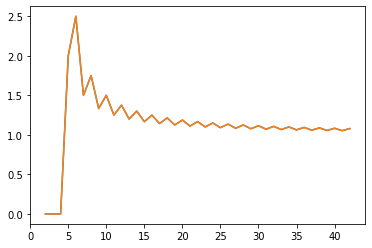

In [682]:
solution = np.array([0.0,
                     0.0,
                     0.0,
                     1e-6,
                     1e-6,
                     1e-6,
                     1e-6])

idx_ana = np.array([3, 4])
N = np.array([2, 2]) 
f_idx = 0

n_inc = 40

from copy import deepcopy 

def fun_test_1(*args, f_idx=f_idx):
    for i, _idx in enumerate(idx_ana):
        solution[_idx] = args[i]
#         print(solution)
    return test_problem.fitness(solution)[f_idx]

vect = np.vectorize(fun_test_1)

bounds_ = np.array(test_problem.get_bounds())[:,idx_ana] 
n_x = bounds_.shape[1]
ret = np.zeros((n_x, 1))
# print(ret)

for i in range(n_inc):
    print(i)
    N_ = N + i
    ana_ = ana(vect, bounds_, N_)
    ret = np.concatenate((ret, ana_), axis=1)

plt.plot(np.array(list(range(n_inc+1)))+N[0], ret.T)
plt.show()

In [11]:
# Save random dataset.

sample_random_data = random_uniform_sample_domain(test_problem.get_bounds(), 6**7)
result_random_data = process_samples(sample_random_data, test_problem)
df_random_sampling = pd.DataFrame(columns=[f"f{i+1}" for i in range(test_problem.fitness_dim)] + [f"x{i+1}" for i in range(len(test_problem.design_space.get_bounds()[0]))], data=result_random_data)
df_random_sampling.to_parquet(f"data/AttitudeTrajectoryProblem2D_C1_R1/dataSet2_randomSampled_6.parquet")

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %


In [13]:
# Save halton dataset

sample_halton_data = halton_sample_domain(test_problem.get_bounds(), 6**7)
result_halton_data = process_samples(sample_halton_data, test_problem)
df_halton_sampling = pd.DataFrame(columns=[f"f{i+1}" for i in range(test_problem.fitness_dim)] + [f"x{i+1}" for i in range(len(test_problem.design_space.get_bounds()[0]))], data=result_halton_data)
df_halton_sampling.to_parquet(f"data/AttitudeTrajectoryProblem2D_C1_R1/dataSet2_haltonSampled_6.parquet")

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %


In [686]:
sample_informed_data = grid_sample_domain(test_problem.get_bounds(), [16, 16, 16, 3, 3, 3, 3])
result_informed_data = process_samples(sample_informed_data, test_problem)
df_informed_sampling = pd.DataFrame(columns=[f"f{i+1}" for i in range(test_problem.fitness_dim)] + [f"x{i+1}" for i in range(len(test_problem.design_space.get_bounds()[0]))], data=result_informed_data)
df_informed_sampling.to_parquet(f"data/AttitudeTrajectoryProblem2D_C1_R1/dataSet2_fftSampled_16_3_3e5.parquet")

sample_informed_data = grid_sample_domain(test_problem.get_bounds(), [16, 16, 16, 4, 4, 4, 4])
result_informed_data = process_samples(sample_informed_data, test_problem)
df_informed_sampling = pd.DataFrame(columns=[f"f{i+1}" for i in range(test_problem.fitness_dim)] + [f"x{i+1}" for i in range(len(test_problem.design_space.get_bounds()[0]))], data=result_informed_data)
df_informed_sampling.to_parquet(f"data/AttitudeTrajectoryProblem2D_C1_R1/dataSet2_fftSampled_16_4_1e6.parquet")

sample_informed_data = grid_sample_domain(test_problem.get_bounds(), [15, 15, 15, 4, 4, 4, 4])
result_informed_data = process_samples(sample_informed_data, test_problem)
df_informed_sampling = pd.DataFrame(columns=[f"f{i+1}" for i in range(test_problem.fitness_dim)] + [f"x{i+1}" for i in range(len(test_problem.design_space.get_bounds()[0]))], data=result_informed_data)
df_informed_sampling.to_parquet(f"data/AttitudeTrajectoryProblem2D_C1_R1/dataSet2_fftSampled_15_4_9e5.parquet")

sample_informed_data = grid_sample_domain(test_problem.get_bounds(), [14, 14, 14, 4, 4, 4, 4])
result_informed_data = process_samples(sample_informed_data, test_problem)
df_informed_sampling = pd.DataFrame(columns=[f"f{i+1}" for i in range(test_problem.fitness_dim)] + [f"x{i+1}" for i in range(len(test_problem.design_space.get_bounds()[0]))], data=result_informed_data)
df_informed_sampling.to_parquet(f"data/AttitudeTrajectoryProblem2D_C1_R1/dataSet2_fftSampled_14_4_7e5.parquet")

sample_informed_data = grid_sample_domain(test_problem.get_bounds(), [13, 13, 13, 4, 4, 4, 4])
result_informed_data = process_samples(sample_informed_data, test_problem)
df_informed_sampling = pd.DataFrame(columns=[f"f{i+1}" for i in range(test_problem.fitness_dim)] + [f"x{i+1}" for i in range(len(test_problem.design_space.get_bounds()[0]))], data=result_informed_data)
df_informed_sampling.to_parquet(f"data/AttitudeTrajectoryProblem2D_C1_R1/dataSet2_fftSampled_13_4_6e5.parquet")

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %


/home/ggarrett/lab/stage/src/problems/two_dimensional/_performance.py:43: RuntimeWarning: invalid value encountered in arccos
  _planet_aux_2 = np.arccos(inner1d(sensor2_pointing_u, body_u)) - np.arcsin(R / (R + h))


60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %


In [687]:
sample_informed_data = grid_sample_domain(test_problem.get_bounds(), [17, 17, 17, 3, 3, 3, 3])
result_informed_data = process_samples(sample_informed_data, test_problem)
df_informed_sampling = pd.DataFrame(columns=[f"f{i+1}" for i in range(test_problem.fitness_dim)] + [f"x{i+1}" for i in range(len(test_problem.design_space.get_bounds()[0]))], data=result_informed_data)
df_informed_sampling.to_parquet(f"data/AttitudeTrajectoryProblem2D_C1_R1/dataSet2_fftSampled_17_3_4e5.parquet")

sample_informed_data = grid_sample_domain(test_problem.get_bounds(), [18, 18, 18, 3, 3, 3, 3])
result_informed_data = process_samples(sample_informed_data, test_problem)
df_informed_sampling = pd.DataFrame(columns=[f"f{i+1}" for i in range(test_problem.fitness_dim)] + [f"x{i+1}" for i in range(len(test_problem.design_space.get_bounds()[0]))], data=result_informed_data)
df_informed_sampling.to_parquet(f"data/AttitudeTrajectoryProblem2D_C1_R1/dataSet2_fftSampled_18_3_5e5.parquet")

sample_informed_data = grid_sample_domain(test_problem.get_bounds(), [19, 19, 19, 3, 3, 3, 3])
result_informed_data = process_samples(sample_informed_data, test_problem)
df_informed_sampling = pd.DataFrame(columns=[f"f{i+1}" for i in range(test_problem.fitness_dim)] + [f"x{i+1}" for i in range(len(test_problem.design_space.get_bounds()[0]))], data=result_informed_data)
df_informed_sampling.to_parquet(f"data/AttitudeTrajectoryProblem2D_C1_R1/dataSet2_fftSampled_19_3_5e6.parquet")

sample_informed_data = grid_sample_domain(test_problem.get_bounds(), [20, 20, 20, 3, 3, 3, 3])
result_informed_data = process_samples(sample_informed_data, test_problem)
df_informed_sampling = pd.DataFrame(columns=[f"f{i+1}" for i in range(test_problem.fitness_dim)] + [f"x{i+1}" for i in range(len(test_problem.design_space.get_bounds()[0]))], data=result_informed_data)
df_informed_sampling.to_parquet(f"data/AttitudeTrajectoryProblem2D_C1_R1/dataSet2_fftSampled_20_3_6e6.parquet")

sample_informed_data = grid_sample_domain(test_problem.get_bounds(), [21, 21, 21, 3, 3, 3, 3])
result_informed_data = process_samples(sample_informed_data, test_problem)
df_informed_sampling = pd.DataFrame(columns=[f"f{i+1}" for i in range(test_problem.fitness_dim)] + [f"x{i+1}" for i in range(len(test_problem.design_space.get_bounds()[0]))], data=result_informed_data)
df_informed_sampling.to_parquet(f"data/AttitudeTrajectoryProblem2D_C1_R1/dataSet2_fftSampled_21_3_8e6.parquet")

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %


In [ ]:

def grid_sample_problem(problem, n=10, scale_bounds=1.0, fixed=(())):
    
    bounds = scale_bounds * np.array(problem.design_space.get_bounds())    
    grid = sampled_grid(bounds, n, flatten=True)
    grid = pd.DataFrame(grid.T, columns=[f"x{i+1}" for i in range(len(grid.T[0]))])
    grid_ = grid
    grid_values = grid_.values
    perc_val = int(0.1 * len(grid_values))
    
    # Generate storage matrix.
    res=np.zeros((grid_.values.shape[0], 12))   # Add f,x shape attribute to problem.
    count=0
    for idx,_x in enumerate(grid_values):
        count+=1
        f = problem.fitness(_x)
        res[idx] = np.concatenate((f,_x))
        if (count % perc_val) == 0:
            print(round(count/len(grid_values) * 100, 1), r"%")
        
    df = pd.DataFrame(columns=[f"f{i+1}" for i in range(problem.fitness_dim)] + [f"x{i+1}" for i in range(len(test_problem.design_space.get_bounds()[0]))], data=res)
#     if os.path.exists("data"):
#         pass
#     else:
#         os.mkdir("data")
        
    save_name = f"data/AttitudeTrajectoryProblem2D_C1_R1/dataSet2_gridSampled_{n}.parquet"
    
    df.to_parquet(save_name)


In [ ]:
for n in np.arange(8,12):
    grid_sample_problem(test_problem, n)
    

## Case 2: Grid Sampled Optimal Region

In [6]:
def grid_sample_solution(problem, solution, n, scale_per_bound=0.025):
#     print(x)
    
    # Get problem bounds.
    bounds = np.array(problem.design_space.get_bounds())
    
    # Transform into bound range.
    bound_range = bounds[1]-bounds[0]
    
#     print(bound_range)
    
    # Scale bound range for about point basis.
    scaled_bound_range = scale_per_bound * bound_range

    # Create new bounds centralised about point.
    bounds = np.concatenate(([solution+scaled_bound_range],[solution-scaled_bound_range]))
    
#     print(bounds.shape)
    
    # Sample bounds about point.
    grid = sampled_grid(bounds, n, flatten=True)
    
#     print(grid.shape)
    
    # Transform to dataframe.
    grid = pd.DataFrame(grid.T, columns=[f"x{i+1}" for i in range(len(grid.T[0]))])
    grid_ = grid
    grid_values = grid_.values
    perc_val = int(0.1 * len(grid_values))
    
    # Generate storage matrix.
    res=np.zeros((grid_.values.shape[0], 12))   # Add f,x shape attribute to problem.
    count=0
    for idx,_x in enumerate(grid_values):
        count+=1
#         print(_x)
        f = problem.fitness(_x)
        res[idx] = np.concatenate((f,_x))
        if (count % perc_val) == 0:
            print(round(count/len(grid_values) * 100, 1), r"%")
        
    df = pd.DataFrame(columns=[f"f{i+1}" for i in range(problem.fitness_dim)] + [f"x{i+1}" for i in range(len(test_problem.design_space.get_bounds()[0]))], data=res)
        
    save_name = f"data/AttitudeTrajectoryProblem2D_C1_R1/dataSet2_sol1_gridSampled_{n}.parquet"
    
    df.to_parquet(save_name)


x = np.array([0.00192016,
             -0.00135844,
              0.00226742,
              0.4064695,
              0.28561942,
              0.96828936,
              0.50069615])

x[-4:] = x[-4:] / np.linalg.norm(x[-4:])

In [ ]:
for n in np.arange(3,12):
    grid_sample_solution(test_problem, x, n, scale_per_bound=0.025)
    

